<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/DRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Python Package Installation

As a first step we check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas','numpy', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow','pyfolio'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install numpy
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4
    !pip install git+https://github.com/quantopian/pyfolio


     |████████████████████████████████| 5.5MB 4.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=dcee81b2bef7d2e8dff8ce269a173224b490be3c926470d55b37f3c34e32732c
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 8.5MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074461 sha256=331968b5cb8b0d4a5a24ecffa6b020997051bc75da769126eab46c762f6ababd
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py
     |████████████████████████████████| 110.5MB 85kB/s 
     |████████████████████████████████| 3.8MB 39.9MB/s 
     |██████████████

## Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')

import yfinance as yf
from stockstats import StockDataFrame as Sdf
import pyfolio

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3, TRPO
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec


# Part 1: Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.

In [3]:
# Dow 30 constituents at 2019/01/01
dow_30_ticker = ['AAPL','MSFT','JPM','V','RTX','PG','GS','NKE','DIS','AXP',
                  'HD','INTC','WMT','IBM','MRK','UNH','KO','CAT','TRV','JNJ',
                  'CVX','MCD','VZ','CSCO','XOM','BA','MMM','PFE','WBA','DD']

In [4]:
# Download and save the data in a pandas DataFrame:
dow_30 = pd.DataFrame()
for tic in dow_30_ticker:
    data_df = yf.download(tic, start="2009-01-01", end="2020-10-23")
    data_df['tic'] = tic
    dow_30=dow_30.append(data_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
dow_30.shape

(89191, 7)

In [6]:
dow_30.head()

,Open,High,Low,Close,Adj Close,Volume,tic
Date,,,,,,,
2008-12-31,3.070357,3.133571,3.047857,3.048214,2.625620,6.075412e+08,AAPL
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.791740,7.460152e+08,AAPL
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.909563,1.181608e+09,AAPL
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.861573,1.289310e+09,AAPL
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.799739,7.530488e+08,AAPL


In [7]:
# reset the index, we want to use numbers instead of dates
dow_30=dow_30.reset_index()

In [8]:
# convert the column names to standardized names
dow_30.columns = ['datadate','open','high','low','close','adjcp','volume','tic']

In [9]:
# convert date to string format, easy to filter
dow_30['datadate']=dow_30.datadate.apply(lambda x: x.strftime('%Y-%m-%d'))

In [10]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.625620,6.075412e+08,AAPL
1,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.791740,7.460152e+08,AAPL
2,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.909563,1.181608e+09,AAPL
3,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.861573,1.289310e+09,AAPL
4,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.799739,7.530488e+08,AAPL


In [11]:
dow_30.shape

(89191, 8)

# Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.

## Check missing data

In [12]:
# check missing data 
dow_30.isnull().values.any()

True

In [13]:
dow_30=dow_30.dropna()

In [14]:
dow_30.tic.value_counts()

MRK     2973
PFE     2973
JNJ     2973
DIS     2973
HD      2973
NKE     2973
MSFT    2973
VZ      2973
INTC    2973
PG      2973
UNH     2973
KO      2973
WBA     2973
IBM     2973
CVX     2973
CSCO    2973
JPM     2973
DD      2973
WMT     2973
RTX     2973
MCD     2973
AAPL    2973
MMM     2973
GS      2973
XOM     2973
CAT     2973
V       2973
TRV     2973
BA      2973
AXP     2973
Name: tic, dtype: int64

In [15]:
# check missing data 
dow_30.isnull().values.any()

False

## Add technical indicators
In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.

In [16]:
def add_technical_indicator(df):
        """
        calcualte technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        stock = Sdf.retype(df.copy())
        stock['close'] = stock['adjcp']
        unique_ticker = stock.tic.unique()

        macd = pd.DataFrame()
        rsi = pd.DataFrame()

        #temp = stock[stock.tic == unique_ticker[0]]['macd']
        for i in range(len(unique_ticker)):
            ## macd
            temp_macd = stock[stock.tic == unique_ticker[i]]['macd']
            temp_macd = pd.DataFrame(temp_macd)
            macd = macd.append(temp_macd, ignore_index=True)
            ## rsi
            temp_rsi = stock[stock.tic == unique_ticker[i]]['rsi_30']
            temp_rsi = pd.DataFrame(temp_rsi)
            rsi = rsi.append(temp_rsi, ignore_index=True)

        df['macd'] = macd
        df['rsi'] = rsi
        return df

In [17]:
dow_30 = add_technical_indicator(dow_30)

In [18]:
dow_30.shape


(89190, 10)

In [19]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.625620,6.075412e+08,AAPL,0.000000,NaN
1,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.791740,7.460152e+08,AAPL,0.003727,100.000000
2,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.909563,1.181608e+09,AAPL,0.008403,100.000000
3,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.861573,1.289310e+09,AAPL,0.008591,84.866792
4,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.799739,7.530488e+08,AAPL,0.006051,70.621528


In [20]:
dow_30.tail()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
89186,2020-10-15,57.990002,59.450001,57.669998,59.279999,59.005932,2952600.0,DD,0.592267,55.558787
89187,2020-10-16,59.450001,59.939999,58.930000,59.169998,58.896442,2805300.0,DD,0.576161,54.004841
89188,2020-10-19,59.349998,60.209999,58.209999,58.439999,58.169815,3827900.0,DD,0.639557,55.825740
89189,2020-10-20,58.680000,60.099998,58.549999,59.480000,59.205009,3722700.0,DD,0.616827,54.079482
89190,2020-10-21,59.160000,60.070000,58.570000,58.660000,58.388802,4201800.0,DD,NaN,NaN


In [21]:
# check missing data 
dow_30.isnull().values.any()

True

In [22]:
dow_30.isna().any()

datadate    False
open        False
high        False
low         False
close       False
adjcp       False
volume      False
tic         False
macd         True
rsi          True
dtype: bool

In [23]:
# fill missing data with forward filling and backward filling
dow_30=dow_30.fillna(method='ffill')
dow_30=dow_30.fillna(method='bfill')


In [24]:
# check missing data 
dow_30.isnull().values.any()

False

In [25]:
dow_30.tail()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi
89186,2020-10-15,57.990002,59.450001,57.669998,59.279999,59.005932,2952600.0,DD,0.592267,55.558787
89187,2020-10-16,59.450001,59.939999,58.930000,59.169998,58.896442,2805300.0,DD,0.576161,54.004841
89188,2020-10-19,59.349998,60.209999,58.209999,58.439999,58.169815,3827900.0,DD,0.639557,55.825740
89189,2020-10-20,58.680000,60.099998,58.549999,59.480000,59.205009,3722700.0,DD,0.616827,54.079482
89190,2020-10-21,59.160000,60.070000,58.570000,58.660000,58.388802,4201800.0,DD,0.616827,54.079482


## Add turbulence index
Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level.

To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [26]:
def add_turbulence(df):
    """
    add turbulence index from a precalcualted dataframe
    :param data: (df) pandas dataframe
    :return: (df) pandas dataframe
    """
    turbulence_index = calcualte_turbulence(df)
    df = df.merge(turbulence_index, on='datadate')
    df = df.sort_values(['datadate','tic']).reset_index(drop=True)
    return df



def calcualte_turbulence(df):
    """calculate turbulence index based on dow 30"""
    # can add other market assets
    
    df_price_pivot=df.pivot(index='datadate', columns='tic', values='adjcp')
    unique_date = df.datadate.unique()
    # start after a year
    start = 252
    turbulence_index = [0]*start
    #turbulence_index = [0]
    count=0
    for i in range(start,len(unique_date)):
        current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
        hist_price = df_price_pivot[[n in unique_date[0:i] for n in df_price_pivot.index ]]
        cov_temp = hist_price.cov()
        current_temp=(current_price - np.mean(hist_price,axis=0))
        temp = current_temp.values.dot(np.linalg.inv(cov_temp)).dot(current_temp.values.T)
        if temp>0:
            count+=1
            if count>2:
                turbulence_temp = temp[0][0]
            else:
                #avoid large outlier because of the calculation just begins
                turbulence_temp=0
        else:
            turbulence_temp=0
        turbulence_index.append(turbulence_temp)
    
    
    turbulence_index = pd.DataFrame({'datadate':df_price_pivot.index,
                                     'turbulence':turbulence_index})
    return turbulence_index

In [27]:
## took about 8 mins to finish
dow_30 = add_turbulence(dow_30)

In [28]:
dow_30.shape

(89190, 11)

In [29]:
dow_30.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
0,2008-12-31,3.070357,3.133571,3.047857,3.048214,2.625620,607541200.0,AAPL,0.000000,100.0,0.0
1,2008-12-31,17.969999,18.750000,17.910000,18.549999,15.110051,9625600.0,AXP,0.014255,100.0,0.0
2,2008-12-31,41.590000,43.049999,41.500000,42.669998,32.005901,5443100.0,BA,0.043418,100.0,0.0
3,2008-12-31,43.700001,45.099998,43.700001,44.669998,31.403988,6277400.0,CAT,0.035331,100.0,0.0
4,2008-12-31,16.180000,16.549999,16.120001,16.299999,12.189656,37513700.0,CSCO,0.011074,100.0,0.0


# Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Environment for Training



In [30]:
## Environment for Training
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

REWARD_SCALING = 1e-4


class StockEnvTrain(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        self.day = day
        self.df = df

        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (121,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False             
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist()
                      #self.data.cci.values.tolist() + \
                      #self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.trades = 0
        self._seed()

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)

        self.state[index+STOCK_DIM+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_train.png')
            plt.close()
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_train.csv')

            return self.state, self.reward, self.terminal,{}

        else:
            actions = actions * HMAX_NORMALIZE
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):61]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward * REWARD_SCALING
            # print("step_reward:{}".format(self.reward))
            
            self.asset_memory.append(end_total_asset)


        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

## Environment for Trading



In [31]:
## Environment for Trading
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0,turbulence_threshold=140):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (121,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[]
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value_trade.png')
            plt.close()
            
            df_date = pd.DataFrame(self.date_memory)
            df_date.columns = ['datadate']
            df_date.to_csv('df_date.csv')
            
            
            df_actions = pd.DataFrame(self.actions_memory)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.datadate                               
            df_actions.to_csv('df_actions.csv')
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value_trade.csv')
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):61]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards_trade.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))
            self.date_memory.append(self.data.datadate.unique())
  
            #print(self.data)
            actions = actions * HMAX_NORMALIZE
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
            self.actions_memory.append(actions)
            
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            #print(argsort_actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.adjcp.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() 
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward * REWARD_SCALING
            
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        #self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[]
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.adjcp.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() 

        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]



# Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

## Training data split: 2009-01-01 to 2018-12-31

In [32]:
def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.datadate >= start) & (df.datadate < end)]
    data=data.sort_values(['datadate','tic'],ignore_index=True)
    data.index = data.datadate.factorize()[0]
    return data

In [33]:
## set up train & test environment
# training env
train = data_split(dow_30, start='2009-01-01', end='2019-01-01')
env_train = DummyVecEnv([lambda: StockEnvTrain(train)])

In [34]:
train.head()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,3.241071,2.791740,746015200.0,AAPL,0.003727,100.000000,0.0
0,2009-01-02,18.570000,19.520000,18.400000,19.330000,15.745411,10955700.0,AXP,0.033824,100.000000,0.0
0,2009-01-02,42.799999,45.560001,42.779999,45.250000,33.941101,7010200.0,BA,0.076722,100.000000,0.0
0,2009-01-02,44.910000,46.980000,44.709999,46.910000,32.978760,7117200.0,CAT,0.026924,72.290025,0.0
0,2009-01-02,16.410000,17.000000,16.250000,16.959999,12.683227,40980600.0,CSCO,0.017589,100.000000,0.0


In [35]:
train.tail()

,datadate,open,high,low,close,adjcp,volume,tic,macd,rsi,turbulence
2515,2018-12-31,131.679993,132.440002,130.229996,131.940002,130.094803,7976000.0,V,-2.421710,46.509202,123.105807
2515,2018-12-31,55.529999,56.230000,55.070000,56.220001,51.129425,15331800.0,VZ,-0.651765,49.101424,123.105807
2515,2018-12-31,68.540001,68.720001,67.739998,68.330002,63.439320,4870900.0,WBA,-3.329318,37.966519,123.105807
2515,2018-12-31,92.669998,93.389999,92.250000,93.150002,89.801826,7005800.0,WMT,-1.209148,48.664463,123.105807
2515,2018-12-31,68.320000,69.150002,67.660004,68.190002,59.254467,15807000.0,XOM,-2.375751,39.556869,123.105807


## Model training: DDPG


In [36]:
## tensorboard --logdir ./multiple_stock_tensorboard/
# add noise to the action in DDPG helps in learning for better exploration
n_actions = env_train.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

# model settings
model_ddpg = DDPG('MlpPolicy', 
                   env_train,
                   batch_size=64,
                   buffer_size=100000,
                   param_noise=param_noise, 
                   action_noise=action_noise,
                   verbose=0, 
                   tensorboard_log="./multiple_stock_tensorboard/")

## 250k timesteps: took about 20 mins to finish
model_ddpg.learn(total_timesteps=250000, tb_log_name="DDPG_run_1")





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





previous_total_asset:1000000
end_total_asset:4576306.603916074
total_reward:3576306.603916074
total_cost:  8812.953247846208
total_trades:  39574
Sharpe:  0.9123793096927748

previous_total_asset:1000000
end_total_asset:4489209.0737739615
total_reward:3489209.0737739615
total_cost:  6469.459879726981
total_trades:  38265
Sharpe:  1.0110743033104796
previous_total_asset:1000000
end_total_asset:5502174.049205098
total_reward:4502174.049205098
total_cost:  3781.792502569737
total_trades:  39090
Sharpe:  1.071500783949316
previous_total_asset:1000000
end_total_asset:4493193.590075691
total_reward:3493193.590075691
total_cost:  6101.291177859566
total_trades:  42963
Sharpe:  0.9185991610988533
prev

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [37]:
insample_turbulence = dow_30[(dow_30.datadate<'2019-01-01') & (dow_30.datadate>='2009-01-01')]
insample_turbulence = insample_turbulence.drop_duplicates(subset=['datadate'])

In [38]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       75.643634
std        38.035979
min         0.000000
25%        57.670537
50%        73.788959
75%        96.805810
max       230.175840
Name: turbulence, dtype: float64

In [39]:
insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.99)

In [40]:
insample_turbulence_threshold

176.34174739959374

### Prepare test data and environment

In [41]:
# test data
test = data_split(dow_30, start='2019-01-01', end='2020-10-30')
# testing env
env_test = DummyVecEnv([lambda: StockEnvTrade(test, turbulence_threshold=insample_turbulence_threshold)])
obs_test = env_test.reset()

### Prediction 

In [42]:
def DRL_prediction(model, data, env, obs):
    print("==============Model Prediction===========")
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

In [43]:
DRL_prediction(model=model_ddpg, 
               data=test,
               env=env_test, 
               obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1177401.4743883505
total_reward:177401.4743883505
total_cost:  24994.48128208065
total trades:  7537
Sharpe:  0.609279707912231


# Part 5: Backtest Our Strategy
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [44]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

## Dow Jones Industrial Average


In [45]:
dji = yf.download("^DJI", start="2019-01-01", end="2020-10-30")
dji=dji.reset_index()
dji.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'adjcp', 'Volume']

[*********************100%***********************]  1 of 1 completed


In [46]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [47]:
## get manual results
get_buy_and_hold_sharpe(dji)

annual return:  11.688774834476966
sharpe ratio:  0.39014966849620303


In [48]:
dji['daily_return']=dji['adjcp'].pct_change(1)

In [49]:
# input for pyfolio
dow_strat = backtest_strat(dji)

## Our DRL trading strategy

In [50]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

In [51]:
## load results
df_account_value = pd.read_csv('account_value_trade.csv',index_col=0)
df_account_value = pd.DataFrame({'account_value':df_account_value['0']})


In [52]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  11.13014985285865
sharpe ratio:  0.6092797079122302


In [53]:
# input for pyfolio
df_account_value['Date'] = dji['Date']
DRL_strat = backtest_strat(df_account_value)

## Plot the results using Quantopian pyfolio
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

Start date,2018-12-31
End date,2020-10-20
Total months,21
,Backtest
Annual return,9.445%
Cumulative returns,17.74%
Annual volatility,17.324%
Sharpe ratio,0.61
Calmar ratio,0.59
Stability,0.40
Max drawdown,-16.057%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.06,2020-06-05,2020-09-23,NaT,NaN
1,13.87,2020-01-15,2020-02-27,2020-06-04,102
2,6.87,2019-07-12,2019-08-13,2019-09-04,39
3,4.51,2019-09-05,2019-10-01,2019-11-11,48
4,3.46,2019-02-22,2019-03-21,2019-04-11,35


d:\vnstudio\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.04%,-8.58%,5.16%


d:\vnstudio\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


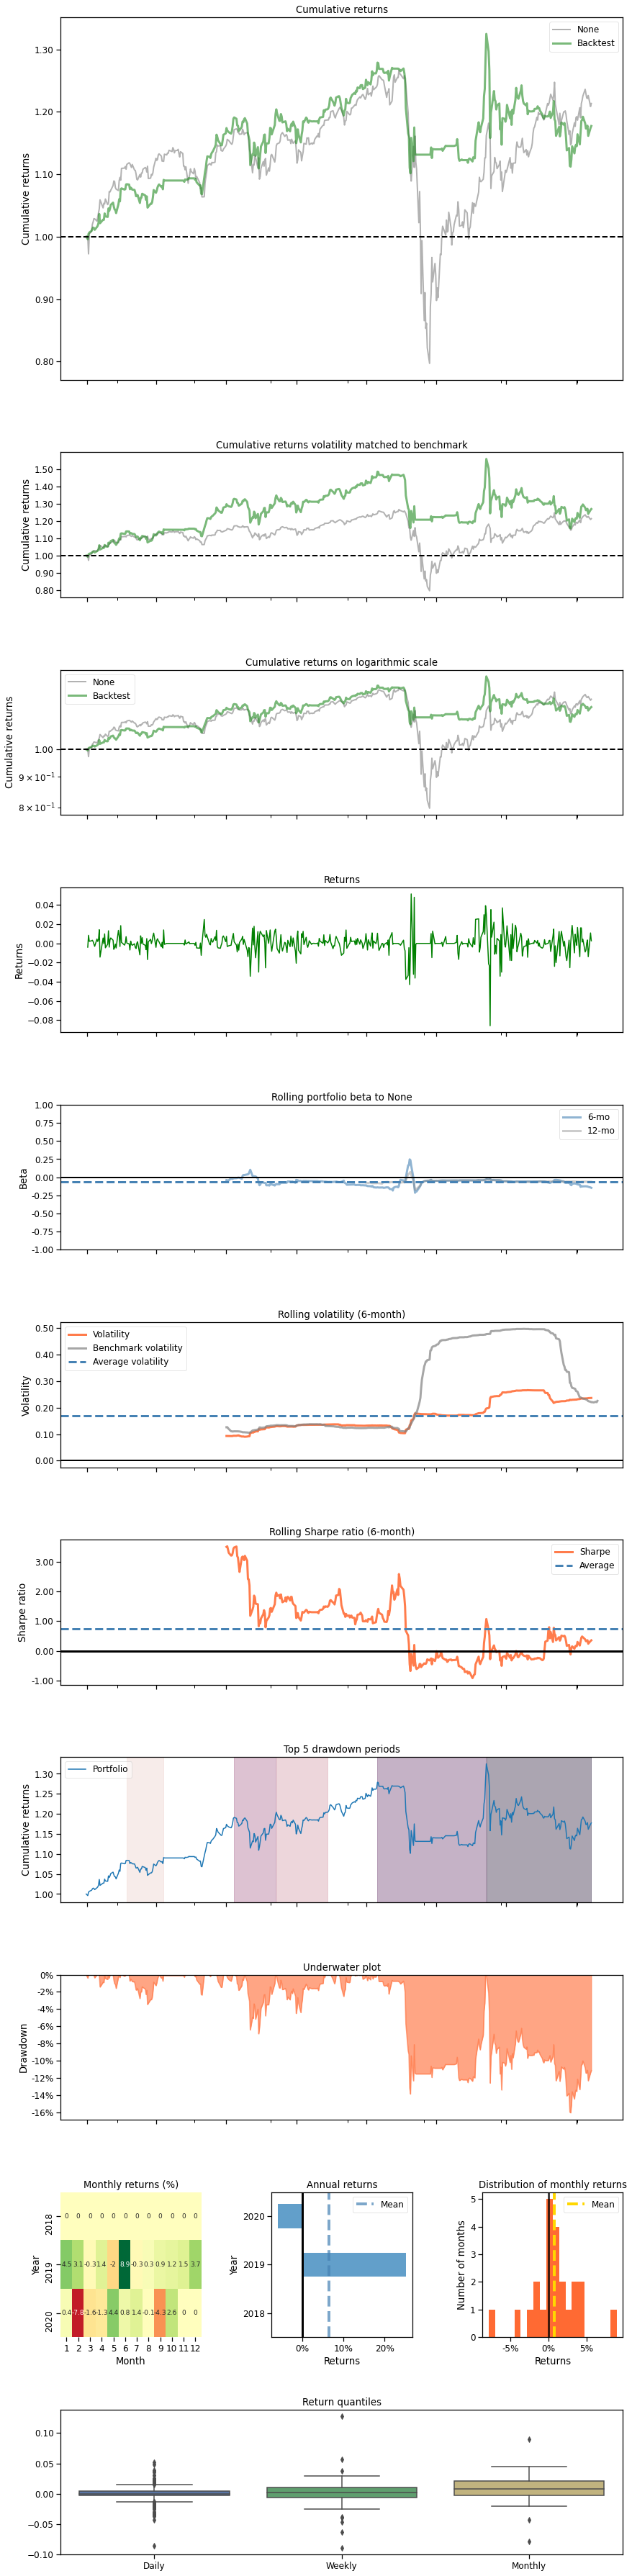

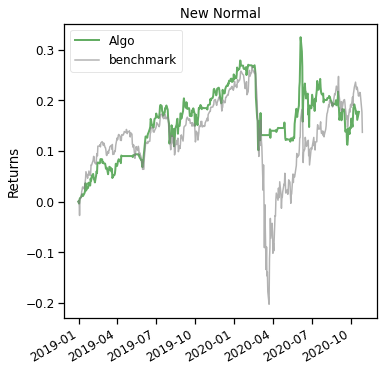

In [54]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                   benchmark_rets=dow_strat, set_context=False)